In [1]:
import os
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [2]:
# we need to append the root directory to the path to import data.py\n",
sys.path.append('..')
import EnergyPricesLibrary as Ep

In [3]:
def build_model(hourly_input_shape,daily_input_shape):
    
    input_1 = tf.keras.layers.Input(shape=hourly_input_shape)
    input_2 = tf.keras.layers.Input(shape=daily_input_shape)
    
    model_1_1 = tf.keras.layers.LSTM(
        units=64,
        activation='tanh',
        kernel_regularizer=tf.keras.regularizers.L1(l1=0),
        dropout=0,
        return_sequences=False
    )(input_1)
    model_1_1 = tf.keras.layers.Dense(units=24,activation=None)(model_1_1)

    model_2_2 = tf.keras.layers.GRU(
            units=320,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0),
            dropout=0,
            return_sequences=True
    )(input_2)
    model_2_2 = tf.keras.layers.GRU(
            units=448,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0),
            dropout=0,
            return_sequences=True
    )(model_2_2)
    model_2_2 = tf.keras.layers.Flatten()(model_2_2)
    model_2_2 = tf.keras.layers.Dense(units=24,activation=None)(model_2_2)
    
    output = tf.keras.layers.Add()([model_1_1, model_2_2])
    output = tf.keras.layers.Dense(units=24,activation=None)(output)
    full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])
    
    return full_model

def make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                     trainX_D, trainY_D, testX_D, testY_D,
                     trainX_H, trainY_H, testX_H, testY_H,
                     n_steps_out,len_output_features):
    
    # make predictions
    trainPredict = model.predict([trainX_H,trainX_D])
    trainPredict = trainPredict.reshape(trainPredict.shape[0]*n_steps_out,len_output_features)
    testPredict  = model.predict([testX_H,testX_D])
    testPredict  = testPredict.reshape(testPredict.shape[0]*n_steps_out,len_output_features)
    
    # invert predictions
    trainPredict = scaler_D_y.inverse_transform(trainPredict)
    trainY = scaler_D_y.inverse_transform(trainY_D.reshape(trainY_D.shape[0]*n_steps_out,len_output_features))
    
    testPredict = scaler_D_y.inverse_transform(testPredict)
    testY = scaler_D_y.inverse_transform(testY_D.reshape(testY_D.shape[0]*n_steps_out,len_output_features))
        
    return trainPredict,trainY,testPredict,testY

def get_metrics(trainY,trainPredict,testY,testPredict):
    
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    trainMAPE  = Ep.MAPE(trainPredict,trainY)
    print('Train Score: %.2f RMSE' % trainScore)
    print('Train Score: %.2f MAPE' % trainMAPE)

    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    testMAPE  = Ep.MAPE(testPredict,testY)
    print('Test Score: %.2f RMSE' % testScore)
    print('Test Score: %.2f MAPE' % testMAPE)
    
    return trainScore,trainMAPE,testScore,testMAPE

In [4]:
data_diaria_path = os.path.join('..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Diaria.xlsx')
data_diaria = pd.read_excel(data_diaria_path)
data_diaria = data_diaria.set_index('Fecha')

In [5]:
data_horaria_path = os.path.join('..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Horaria.xlsx')
data_horaria = pd.read_excel(data_horaria_path)
data_horaria = data_horaria.set_index('Fecha')

In [6]:
precio_bolsa_path = os.path.join('..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Precio_Bolsa.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

In [7]:
nombre_series_diaria = data_diaria.columns.values
nombre_series_horaria = data_horaria.columns.values

In [8]:
data_horaria_full = pd.concat([data_horaria,precio_bolsa],axis=1)

In [9]:
data_horaria.shape,data_diaria.shape, precio_bolsa.shape

((176760, 84), (7365, 119), (176760, 1))

## Build Window

In [10]:
d = 'All'
time_split = '2020-01-01'
n_steps_out=24
output_columns = ['$kWh']

In [11]:
n_steps_in = 2
overlap = 1
inputs_columns = nombre_series_diaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

trainX_D, trainY_D, testX_D, testY_D, scaler_D_x,scaler_D_y, dataset_x_D, dataset_y_D = Ep.SplitTimeseriesMultipleTimesBackAhead_differentTimes(
    df_x=data_diaria,
    df_y=precio_bolsa,
    day = d, 
    TimeSplit = time_split,
    n_steps_out=n_steps_out,
    n_steps_in =n_steps_in, 
    overlap = overlap,
    input_features=inputs_columns,
    output_features=output_columns)

In [12]:
n_steps_in = 48
overlap = 24
inputs_columns = nombre_series_horaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

trainX_H, trainY_H, testX_H, testY_H, scaler_H_x,scaler_H_y, df2_H, dataset_H = Ep.SplitTimeseriesMultipleTimesBackAhead(data_horaria_full,
                                                                                              day = d, 
                                                                                              ValData = 'index', 
                                                                                              TimeAhead = time_split, 
                                                                                              n_steps_out= n_steps_out, 
                                                                                              n_steps_in = n_steps_in, 
                                                                                              overlap = overlap,
                                                                                              input_features=inputs_columns,
                                                                                              output_features=output_columns)

In [13]:
print('Data Diaria')
trainX_D.shape, trainY_D.shape, testX_D.shape, testY_D.shape

Data Diaria


((7272, 2, 119), (7272, 24, 1), (91, 2, 119), (91, 24, 1))

In [14]:
print('Data Horaria')
trainX_H.shape, trainY_H.shape, testX_H.shape, testY_H.shape

Data Horaria


((7272, 48, 84), (7272, 24, 1), (91, 48, 84), (91, 24, 1))

## Model

In [15]:
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          min_lr=1e-5,
                                                          patience=0,
                                                          verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min')

callbacks = [callback_reduce_lr,early_stopping]

In [16]:
hourly_input_shape = (trainX_H.shape[1],trainX_H.shape[2])
daily_input_shape = (trainX_D.shape[1],trainX_D.shape[2])

model = build_model(hourly_input_shape,daily_input_shape)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2, 119)]     0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 2, 320)       423360      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 48, 84)]     0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 2, 448)       1034880     gru[0][0]                        
_______________________________________________________________________________________

In [17]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss=tf.losses.MeanSquaredError(),
              metrics=[tf.metrics.MeanAbsoluteError(),
                       tf.keras.metrics.MeanAbsolutePercentageError()])

In [18]:
import json
model_json = model.to_json()
with open("ModelV2.json", "w") as json_file:
    json_file.write(model_json)

In [19]:
model.fit([trainX_H,trainX_D], trainY_D, validation_data=([testX_H,testX_D],testY_D),
               epochs=200,callbacks=callbacks,verbose=1)

Epoch 1/200
228/228 [==============================] - 4s 15ms/step - loss: 0.0355 - mean_absolute_error: 0.0593 - mean_absolute_percentage_error: 13562.0449 - val_loss: 0.1501 - val_mean_absolute_error: 0.3039 - val_mean_absolute_percentage_error: 282.0492
Epoch 2/200
227/228 [============================>.] - ETA: 0s - loss: 0.0010 - mean_absolute_error: 0.0190 - mean_absolute_percentage_error: 2015.4868
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
228/228 [==============================] - 2s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0190 - mean_absolute_percentage_error: 2013.3611 - val_loss: 0.1512 - val_mean_absolute_error: 0.3031 - val_mean_absolute_percentage_error: 279.6653
Epoch 3/200
228/228 [==============================] - 2s 9ms/step - loss: 8.1666e-04 - mean_absolute_error: 0.0152 - mean_absolute_percentage_error: 1363.8970 - val_loss: 0.1480 - val_mean_absolute_error: 0.2995 - val_mean_absolute_percentage_error: 277.4823
Epoch 

In [20]:
model.evaluate(x=[testX_H,testX_D], y=testY_D)

3/3 [==============================] - 0s 5ms/step - loss: 0.1483 - mean_absolute_error: 0.2993 - mean_absolute_percentage_error: 277.2437


[0.1483273208141327, 0.2992960810661316, 277.24365234375]

In [21]:
trainPredict,trainY,testPredict,testY = make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                                                                              trainX_D, trainY_D, testX_D, testY_D,
                                                                              trainX_H, trainY_H, testX_H, testY_H,
                                                                              n_steps_out,len_output_features)

In [22]:
trainPredict.shape,trainY.shape,testPredict.shape,testY.shape

((174528, 1), (174528, 1), (2184, 1), (2184, 1))

In [23]:
trainScore,trainMAPE,testScore,testMAPE = get_metrics(trainY,trainPredict,testY,testPredict)

Train Score: 77.15 RMSE
Train Score: 0.36 MAPE
Test Score: 1078.37 RMSE
Test Score: 2.55 MAPE


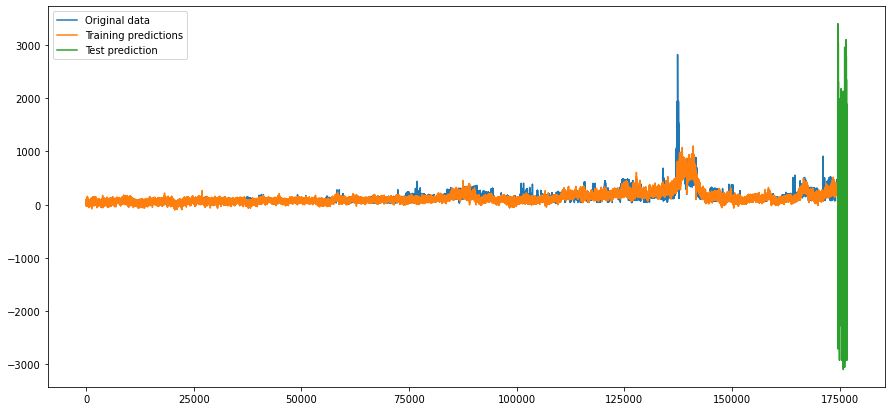

In [24]:
Nt = trainPredict.shape[0] + testPredict.shape[0]
trainPredictPlot = np.zeros((Nt,1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[:len(trainPredict), :] = np.concatenate((dataset_y_D[0].reshape(1,1),trainPredict[:-1]))

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(np.concatenate((trainY,testY)),label='Original data')
plt.plot(trainPredictPlot,label='Training predictions')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()

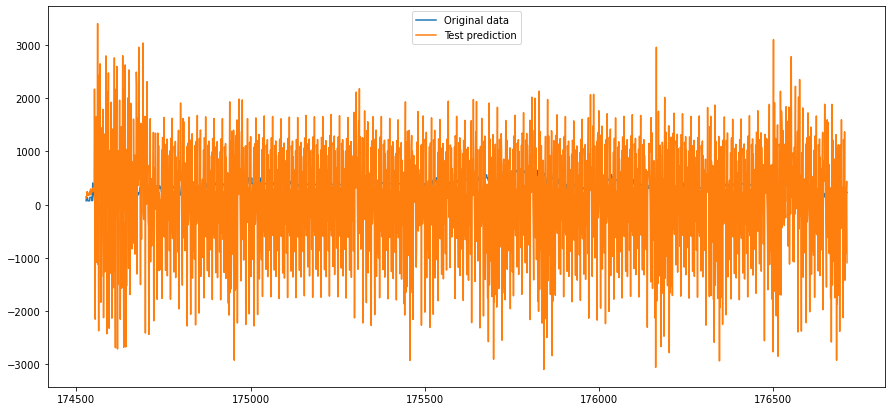

In [25]:
# shift test predictions for plotting
testOriginalPlot = np.zeros((Nt,1))
testOriginalPlot[:, :] = np.nan
testOriginalPlot[len(trainPredict):Nt, :] = testY

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(testOriginalPlot,label='Original data')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()